## Notebook to prepare SODA data to obtain the wind effect


SODA data is downloaded from: 



In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Import data

In [2]:
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/raw'

data = xr.open_mfdataset(f'{path}/*.nc')

In [3]:
data

,Array,Chunk
Bytes,21.77 GiB,543.82 MiB
Shape,"(492, 50, 330, 720)","(12, 50, 330, 720)"
Count,83 Graph Layers,41 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,21.77 GiB,543.82 MiB
Shape,"(492, 50, 330, 720)","(12, 50, 330, 720)"
Count,83 Graph Layers,41 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Data preparations

#### Remove unnecessary variables

In [4]:
data = data.drop(['temp', 'salt', 'wt', 'mlt', 'mlp', 'mls', 'net_heating', 'prho', 'u', 'v', 'taux', 'tauy',
                 'xu_ocean', 'yu_ocean', 'st_ocean', 'sw_ocean'])

#### Remove global mean SSH from data

In [5]:
# Obtain regionally averaged global mean SSH
weights = np.cos(np.deg2rad(data.yt_ocean))
data_weighted = data.weighted(weights)

ssh_global = data_weighted.mean(['xt_ocean', 'yt_ocean'])

# Remove global SSH from soda sea-level signal
data['ssh'] = data['ssh'] - ssh_global.ssh

#### Obtain annual averages

In [6]:
data = data.groupby('time.year').mean('time').rename({'year':'time'})

#### Select data near tide gauge stations

In [7]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']


def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['name'] = stations[:-1]
    df = df.set_index('name')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df


coord_df = station_coords()

In [8]:
data_df = pd.DataFrame({'time' : data.time.data}).set_index('time')

for station in coord_df.index:
    
    # Select data near tide gauge
    data_stat = data.sel(xt_ocean = coord_df['lon'][station], yt_ocean = coord_df['lat'][station], method = 'Nearest').ssh.data
    
    # Obtain anomaly
    data_stat_anom = data_stat - data_stat[0] 
    
    # Save in dataframe
    data_df[station] = data_stat_anom
    
data_df['Average'] = data_df.mean(axis=1)

Text(0.5, 0, 'Time [yr]')

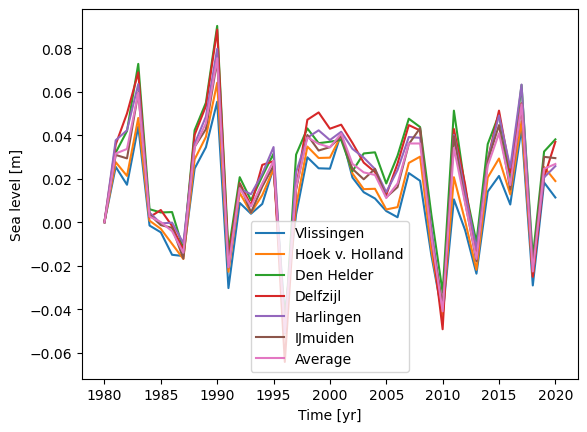

In [9]:
data_df.plot()
plt.ylabel('Sea level [m]')
plt.xlabel('Time [yr]')

In [10]:
data_df

,Vlissingen,Hoek v. Holland,Den Helder,Delfzijl,Harlingen,IJmuiden,Average
time,,,,,,,
1980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1981,0.025441,0.027594,0.032004,0.035759,0.037659,0.030925,0.031564
1982,0.017214,0.021271,0.041911,0.049983,0.042265,0.029333,0.033663
1983,0.044036,0.047902,0.072775,0.068892,0.063503,0.059572,0.059447
1984,-0.001537,0.000706,0.005964,0.002290,0.004438,0.003521,0.002564
1985,-0.004659,-0.003048,0.004469,0.005600,-0.000582,-0.001359,0.000070
1986,-0.014991,-0.009983,0.004650,-0.001744,-0.000215,-0.002583,-0.004144
1987,-0.015567,-0.016922,-0.012407,-0.012949,-0.009623,-0.016731,-0.014033
1988,0.024669,0.028916,0.042301,0.040172,0.036042,0.034662,0.034460


#### Save DataFrame

In [11]:
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/regression input'

data_df.to_csv(f'{path}/sealevel_soda.csv')

The IBE has not been removed